In [1]:
import pywt
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
from skimage import morphology
from skimage.measure import label, regionprops_table
import pandas as pd
import napari
from napari.utils import nbscreenshot
from scipy.interpolate import make_interp_spline
from sklearn.ensemble import RandomForestClassifier
from dtaidistance import dtw
from collections import defaultdict

## Random Composite Signal Generation

In [2]:
seed = 42
np.random.seed(seed)


n_samples = 500
freq = 5
time = np.linspace(0, 1, n_samples)

* Signal1: gaussian
* Signal2: Cardiac AP
* Signal3: Decreasing Monoexponential

C:\Users\mazo260d\AppData\Local\Temp\ipykernel_15176\2929572496.py:2: DeprecationWarning: Importing gaussian from 'scipy.signal' is deprecated and will raise an error in SciPy 1.13.0. Please use 'scipy.signal.windows.gaussian' or the convenience function 'scipy.signal.get_window' instead.
  signal1 = signal.gaussian(30, std=3)


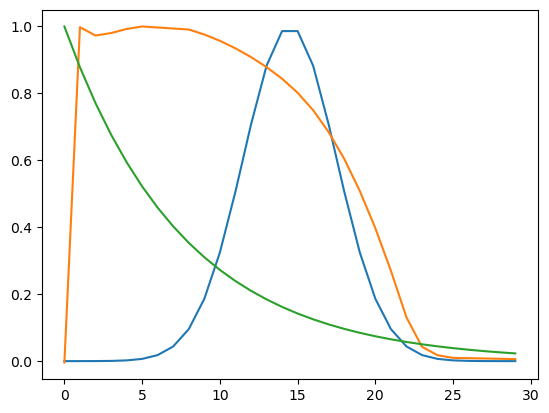

In [3]:
# Signal1: Gaussian
signal1 = signal.gaussian(30, std=3)

# Signal2: Cardiac Ventricular Action Potential
AP_original = np.loadtxt(r"C:\Users\mazo260d\Documents\GitHub\metroid\Simulated_Data\AP.txt",delimiter='\t')
time_sub = np.linspace(0, 5, n_samples) #time vector

# Re-sample at a constant sampling frequency
AP_original[:,0] = AP_original[:,0]/1000                       #ms to sec
xvals = np.arange(AP_original[0,0], AP_original[-1,0], 0.0001) #generate a time vetor with a constant sampling frequency
yinterp = np.interp(xvals, AP_original[:,0], AP_original[:,1]) #interpolate values where original AP time data is missing

# Re-sample by number of samples
yinterp1 = np.interp(time_sub, xvals, yinterp)   #interpolate (extend) data to whole time vector
# Normalize
signal2 = yinterp1
signal2 = signal2+abs(signal2[-1])                          #shift amp from ~-80 to 0
signal2 = signal2/np.amax(signal2)                          #normalize amplitude
# Crop
signal2 = signal2[:30]

# Signal3: Decreasing Monoexponential
def monoexp(x, a, b):
    return a * np.exp(-b * x)
b=0.13
a=1
x = np.arange(30)
signal3 = monoexp(x, a, b)

signals_dict = {0: signal1,
                1: signal2,
                2: signal3}

plt.plot(signal1)
plt.plot(signal2)
plt.plot(signal3)

## Make a random signal composition by adding the three signals with random amplitudes and time shifts

In [4]:
def generate_random_signal_composition(signals_dict, n_samples=500, min_gap=5, max_gap=100):
    composite_signal = np.zeros(n_samples)
    
    position = 0
    while position < n_samples:
        start = position
        # width = np.random.randint(min_width, max(min(max_width, n_samples - position), min_width + 1) + 1)
        signal = signals_dict[np.random.randint(low=0, high=len(signals_dict))]
        width = min(len(signal), n_samples - position)
        composite_signal[start:start+width] = signal[:width]
        position += width + np.random.randint(min_gap, max_gap)  # Move to the end of that window and add some space

    return composite_signal

In [5]:
composite_signal = generate_random_signal_composition(signals_dict=signals_dict)

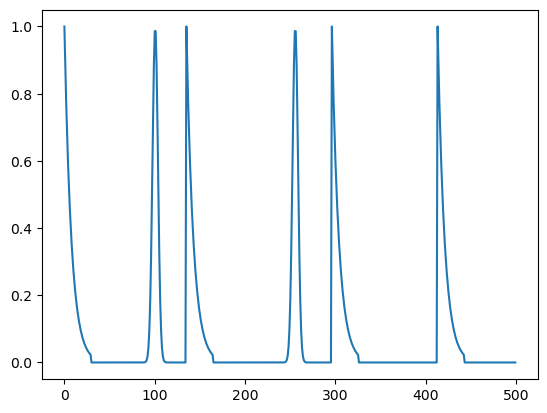

In [6]:
plt.plot(composite_signal)

## Generate random objects

In [7]:
# Generate objects

disk = morphology.disk(4)
square = morphology.square(9)
square[square == 1] = 2
diamond = morphology.diamond(4)
diamond[diamond == 1] = 3
objects_list = [disk, square, diamond]
image = np.zeros((100, 100))
object_order = []
for i in range(10):
    for j in range(3):
        n = np.random.randint(low=2, high=5)
        # obj = objects_list[n]
        obj = morphology.disk(n)
        image[i * 10: i * 10 + (n*2 + 1), 20 + j * 20: 20 + j * 20 + (n*2 + 1)] = obj
        object_order.append(n)

## Add composite signals to objects

In [8]:
# Add signals to label image

label_image = label(image)
height, width = image.shape
time_points = n_samples
time_lapse = np.zeros((time_points, height, width))
for i in range(label_image.max()):
    # print(object_order[i])
    # for label in [1, 2, 3]:
    mask = (label_image == i + 1)  # create boolean mask for current label
    # current_signal = signals[object_order[i]]  # get corresponding signal for current label
    current_signal_category = generate_random_signal_composition(signals_dict)

    # Add random phase by shifting signal
    random_shift = np.random.random()
    current_signal_category = np.roll(current_signal_category, int(random_shift * len(current_signal_category)))

    
    # Add random offset
    current_signal_category = current_signal_category + np.random.random() * 5

    # # Add random window pulses
    # random_windows = generate_random_window_mask()
    # current_signal[~random_windows] = 0

    # Add random noise
    current_signal_category = current_signal_category + np.random.random(size=len(current_signal_category)) / 10

    time_lapse[:, mask] = current_signal_category.reshape((time_points, -1))  # assign signal to region corresponding to current label

## Add mean_intensities of random objects over time to a table

In [9]:
df = pd.DataFrame([])
for i in range(time_points):
    features = regionprops_table(label_image, intensity_image=time_lapse[i], properties=('label', 'mean_intensity'))
    features['frame'] = i
    # data = features.values()
    df = pd.concat([df, pd.DataFrame(features)])

In [10]:
df

,label,mean_intensity,frame
0,1,3.477317,0
1,2,2.538447,0
2,3,1.398264,0
3,4,0.913758,0
4,5,0.505126,0
...,...,...,...
25,26,3.999081,499
26,27,0.277202,499
27,28,0.559926,499
28,29,3.634906,499


## Add data to napari

In [11]:
# viewer = napari.Viewer()
# averages = np.mean(time_lapse, axis=(1, 2))
# viewer.add_image(time_lapse, name='time-lapse')
# table = df

# viewer.add_labels(label_image, features=table, name='labels')

## Annotate some signals

![](./screenshots/signal_annotations1.png)

![](./screenshots/signal_annotations2.png)

In [12]:
# nbscreenshot(viewer)

In [13]:
# nbscreenshot(viewer)

## Save table with annotations to disk

In [14]:
# table = viewer.layers[-1].features

# table.to_csv('table_with_annotations.csv')

table = pd.read_csv('table_with_annotations.csv')
table

,Unnamed: 0,label,mean_intensity,frame,Annotations
0,0,1,3.477317,0,0
1,1,2,2.538447,0,0
2,2,3,1.398264,0,0
3,3,4,0.913758,0,0
4,4,5,0.505126,0,0
...,...,...,...,...,...
14995,14995,26,3.999081,499,0
14996,14996,27,0.277202,499,0
14997,14997,28,0.559926,499,0
14998,14998,29,3.634906,499,0


## Get training data

Get labels where some annotations are present

In [15]:
annotations_mask = table['Annotations'] != 0
labels_with_annotations = np.unique(table[annotations_mask]['label'].values)
labels_with_annotations

array([1, 2, 3], dtype=int64)

In [16]:
# get table rows where label matches labels_with_annotations
table_training = table[table['label'].isin(labels_with_annotations)].sort_values(by=['label', 'frame']).reset_index(drop=True)
table_training

,Unnamed: 0,label,mean_intensity,frame,Annotations
0,0,1,3.477317,0,0
1,30,1,3.499637,1,0
2,60,1,3.433654,2,0
3,90,1,3.455424,3,0
4,120,1,3.434541,4,0
...,...,...,...,...,...
1495,14852,3,1.375912,495,0
1496,14882,3,1.394512,496,0
1497,14912,3,1.449024,497,0
1498,14942,3,1.435429,498,0


## Extract Sub-Signals

In [17]:
class SubSignal:
    def __init__(self, data, category, label, start_frame, end_frame):
        self.data = data  # The signal data
        self.category = category  # The class/annotation of the signal
        self.label = label  # The label of the signal
        self.start_frame = start_frame  # The starting frame of the signal segment
        self.end_frame = end_frame  # The ending frame of the signal segment

    def __repr__(self):
        return f"<SignalSegment category={self.category}, label={self.label}, frames=[{self.start_frame}:{self.end_frame}), data_length={len(self.data)}>"

class SubSignalCollection:
    def __init__(self):
        self.sub_signals = []
        self.categories = []
        self.max_length_per_category = defaultdict(int)

    def add_sub_signal(self, sub_signal):
        self.sub_signals.append(sub_signal)
        if sub_signal.category not in self.categories:
            self.categories.append(sub_signal.category)
        self.max_length_per_category[sub_signal.category] = max(self.max_length_per_category[sub_signal.category], len(sub_signal.data))
    
    def __repr__(self):
        return f"<SubSignalCollection signal categories={self.categories}, number of signals={len(self.sub_signals)}>"
    
    def sort_by_category(self):
        self.sub_signals = sorted(self.sub_signals, key=lambda x: x.category)
    

def extract_sub_signals_by_annotations(df, column_signal_value, column_signal_id, column_signal_annotation, column_frame):
    """
    Extracts sub-signals from a signal data array based on annotations.

    Parameters
    ----------
    df : pd.DataFrame
        The DataFrame containing the signal data.
    column_signal_value : str
        The column name containing the signal data.
    column_signal_id : str
        The column name containing the signal ID (usually the label from image).
    column_signal_annotation : str
        The column name containing the signal annotations.
    column_frame : str
        The column name containing the frame information (time).
    
    Returns
    -------
    list
        A list of SignalSegment objects.
    """
    sub_signal_collection = SubSignalCollection()
    current_signal_category = 0
    start_index = None
    annotations = df[column_signal_annotation].values

    # for i, row in df.iterrows():
    for i, ann in enumerate(annotations):
        if ann > 0:  # Signal detected
            if current_signal_category == 0:  # New signal starts
                current_signal_category = ann
                start_index = i
            elif current_signal_category != ann:  # Different signal detected, save previous
                # Adjusted to include label and frame information
                sub_signal = SubSignal(df[column_signal_value].iloc[start_index:i].values, 
                                       current_signal_category, 
                                       df[column_signal_id].iloc[start_index], 
                                       df[column_frame].iloc[start_index], 
                                       df[column_frame].iloc[i])
                sub_signal_collection.add_sub_signal(sub_signal)
                
                current_signal_category = ann
                start_index = i
        else:  # Noise detected, save previous signal
            if current_signal_category > 0:
                sub_signal = SubSignal(df[column_signal_value].iloc[start_index:i].values, 
                                       current_signal_category, 
                                       df[column_signal_id].iloc[start_index], 
                                       df[column_frame].iloc[start_index], 
                                       df[column_frame].iloc[i])
                sub_signal_collection.add_sub_signal(sub_signal)
                
                current_signal_category = 0
                start_index = None
    
    # Handle the case where the last signal goes until the end
    if current_signal_category > 0:
        sub_signal = SubSignal(df[column_signal_value].iloc[start_index:].values, 
                                       current_signal_category, 
                                       df[column_signal_id].iloc[start_index], 
                                       df[column_frame].iloc[start_index], 
                                       df[column_frame].iloc[-1])
        sub_signal_collection.add_sub_signal(sub_signal)
    
    return sub_signal_collection

def extract_sub_signals_by_annotations_from_arrays(data, annotations, labels, frames):
    """
    Extracts sub-signals from a signal data array based on annotations.

    Parameters
    ----------
    data : np.ndarray
        The signal data array.
    annotations : np.ndarray
        The annotations array.
    labels : np.ndarray
        The labels array.
    frames : np.ndarray
        The frames array.
    
    Returns
    -------
    list
        A list of SignalSegment objects.
    """
    sub_signal_collection = SubSignalCollection()
    sub_signals_list = []
    current_signal = 0
    start_index = None

    for i, ann in enumerate(annotations):
        if ann > 0:  # Signal detected
            if current_signal == 0:  # New signal starts
                current_signal = ann
                start_index = i
            elif current_signal != ann:  # Different signal detected, save previous
                # Adjusted to include label and frame information
                sub_signal = SubSignal(data[start_index:i], current_signal, labels[start_index], frames[start_index], frames[i])
                sub_signal_collection.add_sub_signal(sub_signal)
                
                current_signal = ann
                start_index = i
        else:  # Noise detected, save previous signal
            if current_signal > 0:
                sub_signal = SubSignal(data[start_index:i], current_signal, labels[start_index], frames[start_index], frames[i])
                sub_signal_collection.add_sub_signal(sub_signal)
                
                current_signal = 0
                start_index = None
    
    # Handle the case where the last signal goes until the end
    if current_signal > 0:
        sub_signal = SubSignal(data[start_index:], current_signal, labels[start_index], frames[start_index], frames[-1])
        sub_signal_collection.add_sub_signal(sub_signal)
    
    return sub_signal_collection


In [18]:
# Optional small test
# data1 = np.array([0, 1, 2, 0, 0, 3, 4, 5, 0, 6, 0, 1, 2, 0, 0, 0, 6, 0]) # intensity values
# annotations1 = np.array([0, 1, 1, 0, 0, 2, 2, 2, 0, 3, 0, 1, 1, 0, 0, 0, 3, 0])
# label1 = np.array([1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2])
# frame1 = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 0, 1, 2, 3, 4, 5, 6, 7, 8])
# df = pd.DataFrame({'mean_intensity': data1, 'Annotations': annotations1, 'label': label1, 'frame': frame1})

In [19]:
data = table_training['mean_intensity'].values
annotations = table_training['Annotations'].values
labels = table_training['label'].values
frames = table_training['frame'].values

In [20]:
%%timeit
sub_signal_collection = extract_sub_signals_by_annotations(table_training, 'mean_intensity', 'label', 'Annotations', 'frame')

1.26 ms ± 13.1 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [21]:
%%timeit
sub_signal_collection = extract_sub_signals_by_annotations_from_arrays(data, annotations, labels, frames)

197 µs ± 2.38 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [22]:
sub_signal_collection = extract_sub_signals_by_annotations(table_training, 'mean_intensity', 'label', 'Annotations', 'frame')
sub_signal_collection

<SubSignalCollection signal categories=[1, 2, 3], number of signals=17>

## Calculate features for each annotated signal and put them in a table

Sub_signals may have different lengths depending on the user annotations.

In [23]:
sub_signal_collection.max_length_per_category

defaultdict(int, {1: 32, 2: 32, 3: 23})

In [24]:
sub_signal_collection.sub_signals

[<SignalSegment category=1, label=1, frames=[43:74), data_length=31>,
 <SignalSegment category=2, label=1, frames=[117:144), data_length=27>,
 <SignalSegment category=3, label=1, frames=[166:188), data_length=22>,
 <SignalSegment category=2, label=1, frames=[265:297), data_length=32>,
 <SignalSegment category=3, label=1, frames=[325:347), data_length=22>,
 <SignalSegment category=1, label=1, frames=[413:441), data_length=28>,
 <SignalSegment category=1, label=1, frames=[455:487), data_length=32>,
 <SignalSegment category=3, label=2, frames=[17:36), data_length=19>,
 <SignalSegment category=1, label=2, frames=[118:148), data_length=30>,
 <SignalSegment category=3, label=2, frames=[225:248), data_length=23>,
 <SignalSegment category=1, label=2, frames=[285:314), data_length=29>,
 <SignalSegment category=2, label=2, frames=[410:441), data_length=31>,
 <SignalSegment category=1, label=3, frames=[213:245), data_length=32>,
 <SignalSegment category=1, label=3, frames=[286:317), data_length=3

Use spline interpolation to make all sub_signals have the same length under the corresponding category.
Put resampled signals in a table.

In [25]:
def interpolate_samples(signal, n_samples):
    # Resample the signal segment to a fixed number of samples using spline interpolation
    x = np.arange(len(signal))
    x_new = np.linspace(0, len(signal), n_samples)
    spline = make_interp_spline(x, signal, k=3)
    return spline(x_new)

In [26]:
df_resampled = pd.DataFrame([])
for i, sub_signal in enumerate(sub_signal_collection.sub_signals):
    sub_table = pd.DataFrame(interpolate_samples(sub_signal.data, sub_signal_collection.max_length_per_category[sub_signal.category]), columns=['mean_intensity_interpolated'])
    sub_table['sub_label'] = i + 1
    sub_table['original_label'] = sub_signal.label
    sub_table['original_start_frame'] = sub_signal.start_frame
    sub_table['original_end_frame'] = sub_signal.end_frame
    sub_table['frame_resampled'] = np.linspace(sub_signal.start_frame, sub_signal.end_frame, sub_signal_collection.max_length_per_category[sub_signal.category])
    sub_table['category'] = sub_signal.category

    df_resampled = pd.concat([df_resampled, sub_table], axis=0)
df_resampled

,mean_intensity_interpolated,sub_label,original_label,original_start_frame,original_end_frame,frame_resampled,category
0,3.453399,1,1,43,74,43.0,1
1,3.479164,1,1,43,74,44.0,1
2,4.480783,1,1,43,74,45.0,1
3,4.448369,1,1,43,74,46.0,1
4,4.424114,1,1,43,74,47.0,1
...,...,...,...,...,...,...,...
27,1.428026,17,3,448,479,475.0,2
28,1.494664,17,3,448,479,476.0,2
29,1.482570,17,3,448,479,477.0,2
30,1.415668,17,3,448,479,478.0,2


## Extract sub_signal features

use tsfresh to generate sub_signal features table

In [27]:
# tsfresh syntax for extracting features
from tsfresh import extract_features, extract_relevant_features, select_features
from tsfresh.utilities.dataframe_functions import impute
from tsfresh.feature_extraction import ComprehensiveFCParameters

table_training = df_resampled[['mean_intensity_interpolated', 'sub_label', 'frame_resampled']]

extraction_settings = ComprehensiveFCParameters()

signal_features_table_training = extract_features(table_training, column_id='sub_label', column_sort='frame_resampled',
                     default_fc_parameters=extraction_settings,
                     # we impute = remove all NaN features automatically
                     impute_function=impute)

Feature Extraction: 100%|██████████| 17/17 [00:14<00:00,  1.21it/s]


In [29]:
signal_features_table_training

,mean_intensity_interpolated__variance_larger_than_standard_deviation,mean_intensity_interpolated__has_duplicate_max,mean_intensity_interpolated__has_duplicate_min,mean_intensity_interpolated__has_duplicate,mean_intensity_interpolated__sum_values,mean_intensity_interpolated__abs_energy,mean_intensity_interpolated__mean_abs_change,mean_intensity_interpolated__mean_change,mean_intensity_interpolated__mean_second_derivative_central,mean_intensity_interpolated__median,...,mean_intensity_interpolated__fourier_entropy__bins_5,mean_intensity_interpolated__fourier_entropy__bins_10,mean_intensity_interpolated__fourier_entropy__bins_100,mean_intensity_interpolated__permutation_entropy__dimension_3__tau_1,mean_intensity_interpolated__permutation_entropy__dimension_4__tau_1,mean_intensity_interpolated__permutation_entropy__dimension_5__tau_1,mean_intensity_interpolated__permutation_entropy__dimension_6__tau_1,mean_intensity_interpolated__permutation_entropy__dimension_7__tau_1,mean_intensity_interpolated__query_similarity_count__query_None__threshold_0.0,mean_intensity_interpolated__mean_n_absolute_max__number_of_maxima_7
1,0.0,0.0,0.0,0.0,128.659991,522.925502,0.081638,0.000426,-0.000185,4.193197,...,0.223718,0.578325,0.871781,1.514278,2.237126,2.682016,2.885083,3.044820,0.0,4.476254
2,0.0,0.0,0.0,0.0,119.999916,452.596621,0.088432,-0.003723,-0.003527,3.652348,...,0.223718,0.443757,0.885289,1.436829,2.195649,2.576443,2.791342,2.844614,0.0,4.202124
3,0.0,0.0,0.0,0.0,87.063424,332.479630,0.106469,-0.012378,-0.005613,3.651149,...,0.836988,0.836988,1.098612,1.388204,1.912304,2.086769,2.260204,2.425480,0.0,4.266921
4,0.0,0.0,0.0,0.0,118.658982,442.293133,0.082028,0.005648,0.003175,3.607866,...,0.223718,0.223718,0.885289,1.477087,2.220018,2.642169,2.936427,3.131334,0.0,4.144616
5,0.0,0.0,0.0,0.0,86.962446,331.818210,0.108708,-0.011320,-0.005008,3.624047,...,0.836988,0.836988,1.098612,1.471689,2.121699,2.360736,2.524168,2.670120,0.0,4.271307
6,0.0,0.0,0.0,0.0,130.225233,535.638883,0.083426,-0.005562,-0.001356,4.296854,...,0.443757,0.443757,0.871781,1.004099,1.342574,1.474108,1.511962,1.551888,0.0,4.484893
7,0.0,0.0,0.0,0.0,127.741764,515.859213,0.079952,-0.001402,-0.000553,4.116691,...,0.443757,0.659872,0.871781,1.534027,2.334285,2.738078,2.791342,2.844614,0.0,4.452759
8,0.0,0.0,0.0,0.0,67.285442,199.789528,0.099756,0.004895,0.003150,2.808775,...,0.836988,0.836988,1.098612,1.167389,1.469453,1.645348,1.825564,2.006955,0.0,3.407073
9,0.0,0.0,0.0,0.0,99.674720,316.317221,0.096000,-0.004351,-0.003514,3.302937,...,0.443757,0.443757,0.871781,1.526806,2.081999,2.340664,2.443028,2.497519,0.0,3.554332
10,0.0,0.0,0.0,0.0,65.447069,189.349288,0.107831,-0.009023,-0.005203,2.700742,...,0.836988,0.836988,1.098612,1.089871,1.487798,1.731026,1.985053,2.165976,0.0,3.351060


Annotations are signal categories

In [30]:
annotations = [sub_sig.category for sub_sig in sub_signal_collection.sub_signals]
annotations


[1, 2, 3, 2, 3, 1, 1, 3, 1, 3, 1, 2, 1, 1, 2, 3, 2]

### Train Classifier

In [31]:
random_state = 42
classifier = RandomForestClassifier(random_state=random_state)
classifier_path = 'sub_signal_classifier.pkl'

# X_train = signal_features_table_training.iloc[:, 1:] # remove the first column (the object_id)

# # imput mean to handle NaN values
# imputer = SimpleImputer(missing_values = np.nan, strategy = 'mean', add_indicator=False)
# X_imputed_train = imputer.fit_transform(X_train)

classifier.fit(signal_features_table_training, annotations)

train_score = classifier.score(signal_features_table_training, annotations)
print(train_score)

1.0


## Detect regions of interest

### Generate a template per category/annotation from the training data.

In [56]:
def normalize(signal, method='minmax'):
    if method == 'zscore':
        return (signal - np.mean(signal)) / np.std(signal)
    elif method == 'minmax':
        return (signal - np.min(signal)) / (np.max(signal) - np.min(signal))
    else:
        raise ValueError(f"Unknown normalization method: {method}")

def align_signals(reference, signal):
    alignment = dtw.warping_path_fast(reference, signal)
    
    aligned_signal = np.zeros_like(reference)
    for (i, j) in alignment:
        aligned_signal[i] = signal[j]
    return aligned_signal

# Function to generate template from replicates using median signal as reference
def generate_template_mean(replicates):

    # Use the median signal as the initial reference
    median_signal = np.median(replicates, axis=0)
    
    # Align all replicates to the median signal
    aligned_replicates = [align_signals(median_signal, rep) for rep in replicates]
    # Optionally plot alignment results
    fig, ax = plt.subplots()
    for arep, rep in zip(aligned_replicates, replicates):
        ax.plot(rep, alpha=0.5, color='gray')
        ax.plot(arep, alpha=0.5, color='blue')
    # Compute the average to form the template
    template = np.mean(aligned_replicates, axis=0)
    return template

def generate_templates_by_category(sub_signal_collection):
    """
    Generate templates by category from a list of SignalSegment objects.
    
    Parameters
    ----------
    sub_signal_collection : SubSignalCollection
        The collection of signal segments.

    """
    # Sort the signal segments by category
    sub_signal_collection.sort_by_category()
    
    # Initialize variables
    templates_by_category = {}
    current_category = None
    sub_signals_with_current_category = []

    # Process each signal segment
    for sub_signal in sub_signal_collection.sub_signals:
        if sub_signal.category != current_category:
            # If the category changes, process the current category
            if sub_signals_with_current_category:
                template = generate_template_mean(sub_signals_with_current_category)
                templates_by_category[current_category] = template
                sub_signals_with_current_category = []

            # Update the current category
            current_category = sub_signal.category

        # Normalize and resample the current segment
        target_length = sub_signal_collection.max_length_per_category[current_category]
        resampled_norm_data = interpolate_samples(normalize(sub_signal.data, method='zscore'), target_length)
        sub_signals_with_current_category.append(resampled_norm_data)
    
    # Process the last category
    if sub_signals_with_current_category:
        template = generate_template_mean(sub_signals_with_current_category)
        templates_by_category[current_category] = template

    return templates_by_category

Benchmark generate_template functions

In [32]:
replicates_for_benchmark = [interpolate_samples(normalize(sub_signal.data), sub_signal_collection.max_length_per_category[1]) for sub_signal in sub_signal_collection.sub_signals if sub_signal.category == 1]

In [33]:
%%timeit
generate_template_mean(replicates_for_benchmark)

56.1 ms ± 1.4 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


generate template function is quite slow (PCA approach deforms signals)

Plot templates and compare them to the original signals

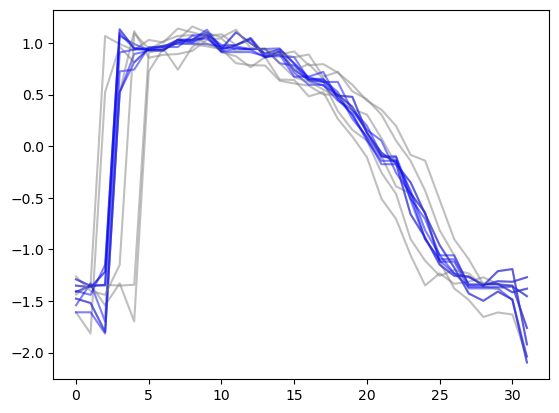

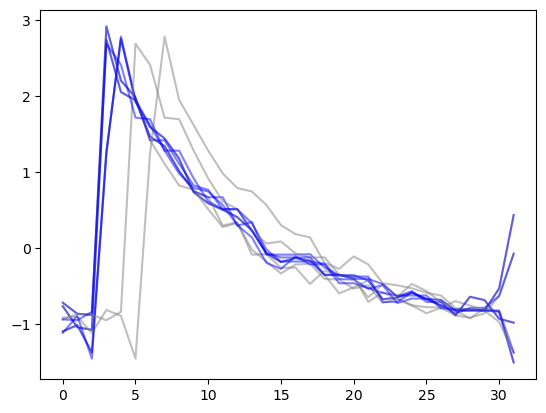

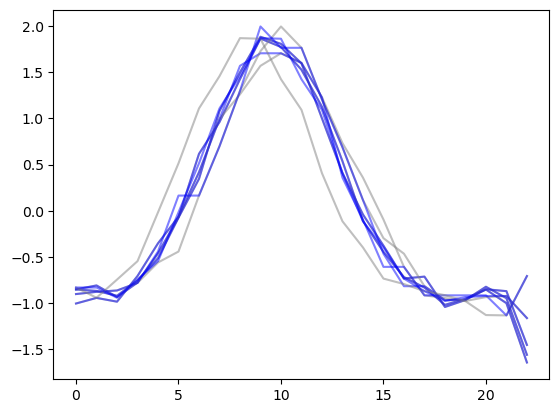

In [57]:
sub_signal_templates = generate_templates_by_category(sub_signal_collection)

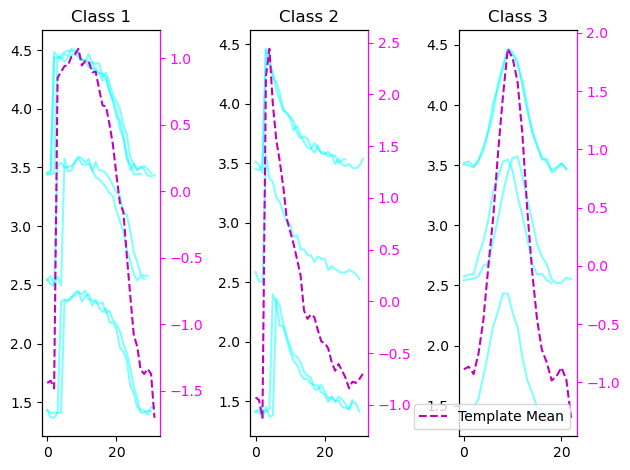

In [58]:
# Plot all signals separated by class in a different column
fig, ax = plt.subplots(1, len(sub_signal_templates))
for sub_sig in sub_signal_collection.sub_signals:
    ax[sub_sig.category-1].plot(sub_sig.data, 'cyan', alpha=0.5)
    ax[sub_sig.category-1].set_title(f'Class {sub_sig.category}')

for i, template_mean in sub_signal_templates.items():
    ax2 = ax[i-1].twinx()
    ax2.yaxis.label.set_color('magenta')
    ax2.tick_params(axis='y', colors='magenta')
    ax2.spines['right'].set_color('magenta')
    ax2.plot(template_mean, 'm--', label='Template Mean')
ax2.legend()
plt.tight_layout()

## Detect regions of interest
Find peaks by thresholding cross-correlation and get a region around them.
Develop some strategy to collect these regions without duplication (or collect duplication, but assign some weight or probability to them)


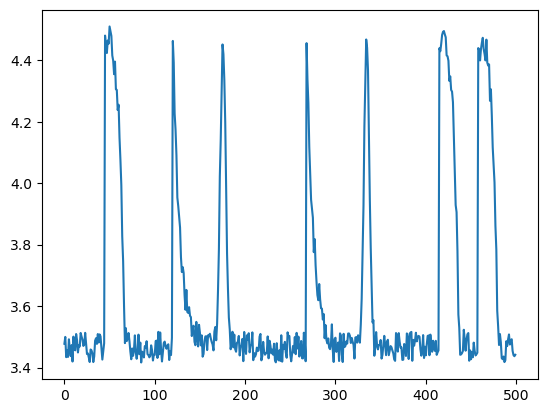

In [59]:
composite_signal1 = table[(table['label'] == 1)].sort_values(by=['label', 'frame']).reset_index(drop=True)['mean_intensity'].values
plt.plot(composite_signal1)

Calculate cross-correlation between each normalized signal class and whole normalized annotated composite signal and plot results

In [60]:
sub_signal_collection.categories

[1, 2, 3]

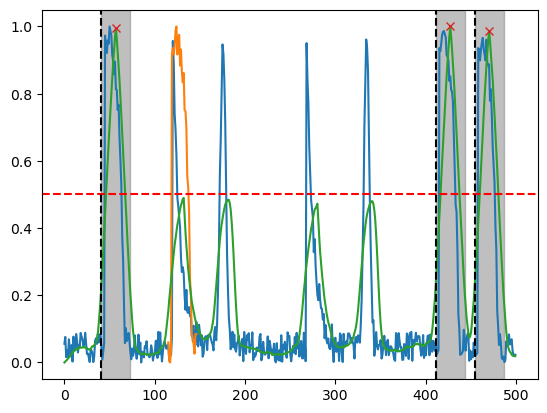

In [61]:
threshold = 0.5

composite_signal_normalized = (composite_signal1 - np.amin(composite_signal1))/np.ptp(composite_signal1)
sub_signal_normalized = (sub_signal.data - np.amin(sub_signal.data))/np.ptp(sub_signal.data)
cross_corr = signal.correlate(composite_signal_normalized, sub_signal_normalized, mode='same')
normalized_corr = (cross_corr - np.min(cross_corr)) / np.ptp(cross_corr)
peaks, _ = signal.find_peaks(normalized_corr, height=threshold)

plt.plot(composite_signal_normalized)
plt.plot(np.arange(115, 115+len(sub_signal_normalized)), sub_signal_normalized)
plt.plot(normalized_corr)
plt.plot(peaks, normalized_corr[peaks], "x")
plt.axhline(y=threshold, color='r', linestyle='--')
for peak in peaks:
    plt.axvspan(peak-len(sub_signal_normalized)/2, peak+len(sub_signal_normalized)/2, color='gray', alpha=0.5)
    plt.axvline(x=peak-len(sub_signal_normalized)/2, color='k', linestyle='--')


In [39]:
len(sub_signal_templates)

3

- Options here are:
  - use minmax normalization of signal and template followed by minmax normalization of cross-correlation plus thresholding
  - or zscore normalization of signal and template followed by normalizing cross-correlation by energy of signal and template plus thresholding

Currently using the second one below (first is commented). Obs: threshold plotted is for the first option.

## Stopped here

Next steps:
- check whether this is enough to ID sub_signals (no Random Forest Classifier), but it seems not (it detects more sub_signals per category, check the exponential example below, maybe thresholding it differently could solve it)
- if not, train a classifier to detect sub_signals and find a way to assign unique classes to them
- try wavelet transform to detect sub_signals as an alternative to both methods above

5.623826995805066
5.587840179641812
4.778535375222671


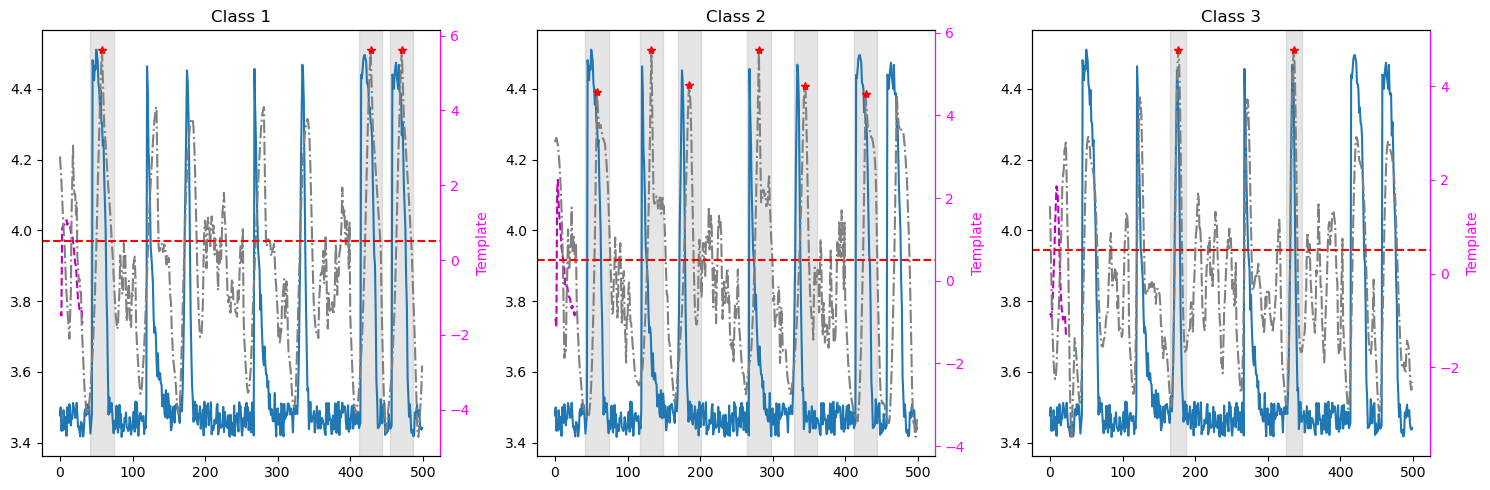

In [65]:
def detect_signal(composite_signal, template, threshold, return_cross_corr=False, norm_method='minmax'):
    composite_signal_norm = normalize(composite_signal, method=norm_method)
    template_norm = normalize(template, method=norm_method)
    cross_corr = signal.correlate(composite_signal_norm, template_norm, mode='same') # default method already chooses between fft and direct

    # Normalizing cross-correlation by energy of signal and template
    fm2 = signal.correlate(composite_signal_norm**2, np.ones_like(template_norm), mode='same', ) # Convolution of the squared composite signal with a window of ones
    fm = signal.correlate(composite_signal_norm, np.ones_like(template_norm), mode='same') # Convolution of the composite signal with a window of ones
    n = len(template)
    denominator = np.sqrt(fm2 - fm**2/n)
    normalized_corr = cross_corr/denominator
    print(np.max(normalized_corr))
    threshold = np.max(normalized_corr) * 0.8

    # Normalizing cross-correlation by minmax directly
    # normalized_corr = normalize(cross_corr, method=norm_method)
    
    peaks_indices, _ = signal.find_peaks(normalized_corr, height=threshold)
    if return_cross_corr:
        return peaks_indices, normalized_corr
    return peaks_indices

threshold=0.5
fig, ax = plt.subplots(1, len(sub_signal_templates), figsize=(15, 5))
for i, sub_signal in enumerate(sub_signal_templates.values()):
    peaks_indices, normalized_cross_corr = detect_signal(composite_signal1, sub_signal, threshold, return_cross_corr=True, norm_method='zscore')
    ax[i].plot(composite_signal1, label='Composite Signal')
    ax2 = ax[i].twinx()
    ax2.plot(sub_signal, 'm--', label='Template')
    ax2.yaxis.label.set_color('magenta')
    ax2.tick_params(axis='y', colors='magenta')
    ax2.spines['right'].set_color('magenta')
    ax2.set_ylabel('Template', color='magenta')
    ax2.plot(normalized_cross_corr, '-.', color='gray', label='Normalized Cross-Correlation')
    ax2.plot(peaks_indices, normalized_cross_corr[peaks_indices], 'r*', label='Detected Peaks')
    ax2.axhline(y=threshold, color='r', linestyle='--')
    for peak_index in peaks_indices:
        ax[i].axvspan(peak_index-np.floor(len(sub_signal)/2), peak_index+np.floor(len(sub_signal)/2), color='gray', alpha=0.2)
    ax[i].set_title(f'Class {i+1}')
plt.tight_layout()



In [46]:
sub_signal_templates

{1: array([ 3.40984491e-02,  2.01789970e-02,  9.29576468e-04,  9.07067325e-01,
         9.52999356e-01,  9.18750514e-01,  9.45459557e-01,  9.50321613e-01,
         9.91901013e-01,  9.86256143e-01,  9.76233357e-01,  9.67018418e-01,
         9.26030926e-01,  9.21828395e-01,  9.06733792e-01,  8.45941636e-01,
         8.54178967e-01,  8.13052474e-01,  7.82313628e-01,  7.32320007e-01,
         6.74222889e-01,  5.73209755e-01,  4.94031157e-01,  4.64034733e-01,
         3.59475584e-01,  2.04098731e-01,  1.03077171e-01,  5.79454015e-02,
         2.68006167e-02,  3.83954772e-02,  3.38655757e-02, -8.41659103e-02]),
 2: array([ 0.04077139,  0.03398569, -0.01648731,  0.87110976,  0.85764274,
         0.76536513,  0.68278624,  0.68278624,  0.63890016,  0.53129456,
         0.47674242,  0.43735468,  0.38805727,  0.33977076,  0.26788537,
         0.27244189,  0.23935319,  0.22696539,  0.22577034,  0.16431103,
         0.177757  ,  0.15340115,  0.13165851,  0.10574665,  0.12475152,
         0.09797997

In [70]:
def extract_sub_signals_by_templates(df, column_signal_value, column_signal_id, column_frame, sub_signal_templates, threshold, method='zscore'):
  
    sub_signal_collection = SubSignalCollection()
    grouped_by_label = df.groupby(column_signal_id, sort=False) # column_signal_id = 'label'
    for label, sub_table in list(grouped_by_label):
        composite_signal = sub_table[column_signal_value].values # column_signal_value = 'mean_intensity'
        # for each composite signal, detect sub_signals using the templates
        for k, template in sub_signal_templates.items():
            peaks_indices = detect_signal(composite_signal, template, threshold, norm_method=method)
            # Collect the sub_signals around each peak
            for peak_index in peaks_indices:
                # Add the sub_signal to the collection with the template category, original label and frame information
                start_index = int(peak_index-np.floor(len(template)/2))
                end_index = int(peak_index+np.floor(len(template)/2))
                # If sub_signal would start before composite signal, set start frame to 0
                if start_index < 0:
                    start_index = 0
                # If sub_signal would end after composite signal, set end frame to the last frame
                if end_index > len(composite_signal):
                    end_index = len(composite_signal)
                sub_signal = SubSignal(composite_signal[start_index:end_index],
                                    k, 
                                    label, 
                                    sub_table[column_frame].values[start_index], 
                                    sub_table[column_frame].values[end_index-1]
                                    )
                sub_signal_collection.add_sub_signal(sub_signal)
    return sub_signal_collection


In [71]:
sub_signal_collection = extract_sub_signals_by_templates(table, 'mean_intensity', 'label', 'frame', sub_signal_templates, threshold)
sub_signal_collection

5.623826995805066
5.587840179641812
4.778535375222671
5.61787824287621
5.570401247734328
4.771946432791126
5.612791070551254
5.597297188524037
4.770960061012912
5.6146748028464355
5.56021256810503
4.768523195905252
5.612320629038281
4.6874477678607045
4.766444829350107
5.622029350401517
4.978383340258034
3.7581115210195897
5.605387698963268
5.592057709676818
4.300656869068718
5.6081943102331095
5.576488020398014
3.7649567919836198
5.61454710994369
5.587779879443045
4.765175638329925
5.61961320201
5.577904368634005
3.818354588217347
5.601051311483295
5.585548974104747
4.769733506215809
5.607752815663729
5.567049900698896
4.764894525994233
5.607527254319761
4.760474636426958
4.772297273226499
5.60900887753851
5.55357579251083
4.76859133300474
5.604623232936883
5.582117647799135
4.773601190111911
4.209757157759921
5.599978724037347
4.777692320519873
5.614711512064002
4.9229029795407575
4.767437264919842
5.610402190068702
5.575571947768424
4.7679977882782065
5.618443579649668
5.58230717513

<SubSignalCollection signal categories=[1, 2, 3], number of signals=350>

Turn collected signals into a table to extract features with tsfresh
No need to resample them since they were collected via template of fixed length

In [72]:
df_resampled = pd.DataFrame([])
for i, sub_signal in enumerate(sub_signal_collection.sub_signals):
    sub_table = pd.DataFrame(sub_signal.data, columns=['mean_intensity'])
    sub_table['sub_label'] = i + 1
    sub_table['original_label'] = sub_signal.label
    sub_table['original_start_frame'] = sub_signal.start_frame
    sub_table['original_end_frame'] = sub_signal.end_frame
    sub_table['frame'] = np.linspace(sub_signal.start_frame, sub_signal.end_frame, len(sub_signal.data))
    sub_table['category'] = 0
    sub_table['template_category'] = sub_signal.category

    df_resampled = pd.concat([df_resampled, sub_table], axis=0)
df_resampled

,mean_intensity,sub_label,original_label,original_start_frame,original_end_frame,frame,category,template_category
0,3.425859,1,1,42,73,42.0,0,1
1,3.453399,1,1,42,73,43.0,0,1
2,3.479164,1,1,42,73,44.0,0,1
3,4.480783,1,1,42,73,45.0,0,1
4,4.448369,1,1,42,73,46.0,0,1
...,...,...,...,...,...,...,...,...
17,1.140673,350,30,219,240,236.0,0,3
18,1.079643,350,30,219,240,237.0,0,3
19,1.148125,350,30,219,240,238.0,0,3
20,1.145647,350,30,219,240,239.0,0,3


## Extract sub_signal features for test data

In [73]:
table_test = df_resampled[['mean_intensity', 'sub_label', 'frame']]
table_test.columns = ['mean_intensity_interpolated', 'sub_label', 'frame']

extraction_settings = ComprehensiveFCParameters()

signal_features_table_test = extract_features(table_test, column_id='sub_label', column_sort='frame',
                     default_fc_parameters=extraction_settings,
                     # we impute = remove all NaN features automatically
                     impute_function=impute)

Feature Extraction: 100%|██████████| 40/40 [00:27<00:00,  1.45it/s]


In [80]:
table_test['sub_label'].max()

469

In [79]:
# each row is a different sub_signal (which could be replicates due to the template matching process)
signal_features_table_test

,mean_intensity_interpolated__variance_larger_than_standard_deviation,mean_intensity_interpolated__has_duplicate_max,mean_intensity_interpolated__has_duplicate_min,mean_intensity_interpolated__has_duplicate,mean_intensity_interpolated__sum_values,mean_intensity_interpolated__abs_energy,mean_intensity_interpolated__mean_abs_change,mean_intensity_interpolated__mean_change,mean_intensity_interpolated__mean_second_derivative_central,mean_intensity_interpolated__median,...,mean_intensity_interpolated__fourier_entropy__bins_5,mean_intensity_interpolated__fourier_entropy__bins_10,mean_intensity_interpolated__fourier_entropy__bins_100,mean_intensity_interpolated__permutation_entropy__dimension_3__tau_1,mean_intensity_interpolated__permutation_entropy__dimension_4__tau_1,mean_intensity_interpolated__permutation_entropy__dimension_5__tau_1,mean_intensity_interpolated__permutation_entropy__dimension_6__tau_1,mean_intensity_interpolated__permutation_entropy__dimension_7__tau_1,mean_intensity_interpolated__query_similarity_count__query_None__threshold_0.0,mean_intensity_interpolated__mean_n_absolute_max__number_of_maxima_7
1,0.0,0.0,0.0,0.0,128.619236,522.644601,0.082054,0.000842,-0.001022,4.193197,...,0.443757,0.443757,0.871781,1.534027,2.314690,2.682016,2.885083,3.044820,0.0,4.476254
2,0.0,0.0,0.0,0.0,128.599320,522.667099,0.073211,0.001642,-0.000649,4.209928,...,0.443757,0.443757,0.871781,1.354025,1.796592,2.192132,2.460740,2.627560,0.0,4.474992
3,0.0,0.0,0.0,0.0,128.360506,520.622372,0.079342,-0.000112,0.000086,4.169054,...,0.443757,0.659872,0.871781,1.534027,2.380536,2.898746,2.997793,3.044820,0.0,4.449651
4,0.0,0.0,0.0,0.0,128.619236,522.644601,0.082054,0.000842,-0.001022,4.193197,...,0.443757,0.443757,0.871781,1.534027,2.314690,2.682016,2.885083,3.044820,0.0,4.476254
5,0.0,0.0,0.0,0.0,119.068298,445.499072,0.078970,0.000496,-0.000275,3.592189,...,0.223718,0.223718,0.659872,1.414175,2.238678,2.647685,2.846324,2.948589,0.0,4.175432
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
465,0.0,0.0,0.0,0.0,43.195639,60.662755,0.086358,0.000553,-0.000894,1.244148,...,0.223718,0.223718,0.659872,1.541940,2.238678,2.526933,2.679706,2.734198,0.0,1.794374
466,0.0,0.0,0.0,0.0,41.493708,80.191339,0.090072,0.020318,-0.003344,2.010679,...,0.450561,0.566086,1.098612,1.583276,2.406160,2.707270,2.751667,2.772589,0.0,2.099262
467,0.0,0.0,0.0,0.0,31.766314,48.535928,0.104957,0.002935,-0.002375,1.266592,...,0.836988,0.836988,1.098612,1.235347,1.731026,1.985053,2.165976,2.339372,0.0,1.905219
468,0.0,0.0,0.0,0.0,32.076053,49.019814,0.097529,0.007801,0.000690,1.377572,...,0.836988,1.098612,1.907284,1.444646,2.013806,2.351257,2.557794,2.685945,0.0,1.861961


## Predict sub_signal categories

In [74]:
# predict sub_signal categories
predictions = classifier.predict(signal_features_table_test)

In [78]:
predictions

array([1, 1, 1, 1, 2, 2, 2, 2, 1, 1, 1, 2, 3, 2, 3, 1, 1, 1, 1, 2, 1, 2,
       1, 2, 3, 1, 3, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 1, 1, 1, 1,
       2, 3, 2, 1, 1, 2, 2, 2, 1, 2, 1, 2, 2, 3, 2, 1, 2, 2, 2, 1, 1, 1,
       1, 1, 2, 1, 1, 2, 1, 1, 3, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 2, 2, 2, 1,
       1, 1, 1, 2, 2, 2, 1, 1, 1, 1, 1, 2, 2, 1, 2, 1, 1, 2, 2, 1, 2, 1,
       1, 1, 1, 2, 1, 2, 2, 1, 3, 2, 2, 3, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2,
       2, 1, 1, 1, 1, 2, 2, 2, 1, 2, 1, 2, 2, 1, 2, 2, 2, 2, 1, 2, 1, 3,
       2, 3, 3, 1, 1, 1, 2, 2, 2, 2, 1, 1, 2, 2, 3, 2, 3, 1, 1, 3, 1, 1,
       1, 2, 2, 1, 2, 1, 2, 1, 3, 3, 1, 3, 1, 3, 1, 1, 1, 1, 1, 2, 2, 2,
       1, 1, 1, 2, 3, 3, 1, 1, 1, 2, 2, 2, 2, 1, 2, 2, 3, 3, 3, 1, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 3, 3, 2, 1, 1, 2, 1, 1,
       2, 2, 2, 3, 1, 1, 3, 3, 3, 1, 2, 2, 2, 2, 1, 2, 2, 3, 3, 3, 1, 3,
       1, 1, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 3, 2, 2,

In [98]:
observed_label = 30

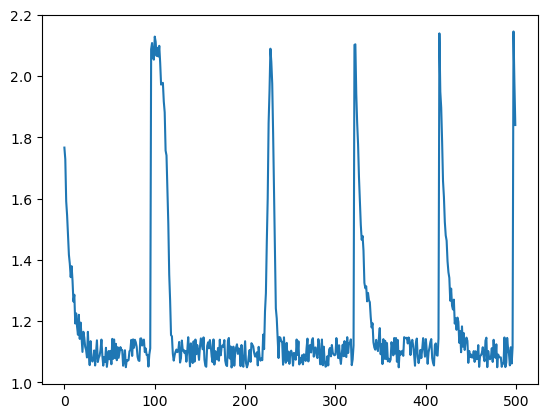

In [99]:
plt.plot(df[df['label'] == observed_label]['mean_intensity'].values)

In [108]:
first_grouped_by_sub_label = df_resampled.groupby('sub_label').first().reset_index()
first_grouped_by_sub_label['predicted_category'] = predictions
first_grouped_by_sub_label[first_grouped_by_sub_label['original_label'] == observed_label]

,sub_label,mean_intensity,original_label,original_start_frame,original_end_frame,frame,category,template_category,predicted_category
459,460,1.051735,30,93,124,93.0,0,1,1
460,461,1.056382,30,318,349,318.0,0,1,2
461,462,1.051735,30,93,124,93.0,0,2,1
462,463,1.231819,30,222,253,222.0,0,2,2
463,464,1.056382,30,318,349,318.0,0,2,2
464,465,1.088830,30,412,443,412.0,0,2,2
465,466,1.091275,30,94,115,94.0,0,3,1
466,467,1.072567,30,219,240,219.0,0,3,3
467,468,1.128415,30,315,336,315.0,0,3,2
468,469,1.063444,30,408,429,408.0,0,3,2


In [97]:
predictions[-20:]

array([2, 1, 1, 1, 2, 2, 3, 1, 1, 1, 1, 2, 1, 2, 2, 2, 1, 3, 2, 2],
      dtype=int64)

Idea
- Expand predicitons column to fill whole table
- For each time-point in each label, give a weighted vote to the category of that time-point based on the predictions (give higher weight to matching detections)

In [77]:
df_resampled['predictions'] = predictions
df_resampled

ValueError: Length of values (469) does not match length of index (12940)

In [ ]:
viewer = napari.Viewer()
# averages = np.mean(time_lapse, axis=(1, 2))
# viewer.add_image(time_lapse, name='time-lapse')
# table = df

# viewer.add_labels(label_image, features=table, name='labels')

## Get all windows where there is a high cross-correlation peak, calculate the same features and add them to the table with annotation class 0

Display wavelet coefficients for each signal

In [23]:
len(signals_by_class[1][0])

31

In [24]:
# First signal of class 1 = signals_by_class[1][0]
waveletname = 'db4'
# Get max level of discrete wavelet
max_level_of_decomposition = pywt.dwt_max_level(len(signals_by_class[1][0]), waveletname)
print(max_level_of_decomposition)


2


In [25]:
def make_list_of_coefficients_names(waveletname, max_level_of_decomposition):
    list_coefficients_names = [waveletname + '_cA_' + str(max_level_of_decomposition)]
    list_coefficients_names += [waveletname + '_cD_' + str(i) for i in range(max_level_of_decomposition, 0, -1)]
    return list_coefficients_names

In [26]:
list_wavelet_coefficients = pywt.wavedec(signals_by_class[1][0], waveletname, level=max_level_of_decomposition)
# list_of_wavelet_decomposition_level_names = make_list_of_coefficients_names(waveletname, max_level_of_decomposition)
list_wavelet_coefficients

[array([8.45641474, 7.2552391 , 9.22873853, 7.6903417 , 7.88126519,
        8.9506319 , 8.90890409, 8.7053209 , 8.47328454, 7.62091933,
        7.04237105, 6.95136322, 6.93967763]),
 array([-0.20218199, -0.5755312 ,  0.53312635, -0.1546327 , -0.00538744,
        -0.00606577, -0.00172286, -0.08456947,  0.08235799, -0.02600053,
         0.00195876, -0.03983206,  0.09999511]),
 array([ 0.17354602,  0.44541506, -0.19104386,  0.02377394, -0.01103984,
        -0.02120041, -0.01753815, -0.04454506, -0.02139769, -0.03030507,
         0.02486697,  0.02785961, -0.04129259, -0.01551608,  0.01455138,
        -0.01677421,  0.01666999, -0.01807835,  0.03788132])]

In [27]:
max_level_of_decomposition2 = pywt.dwt_max_level(len(signals_by_class[2][0]), waveletname)
list_wavelet_coefficients2 = pywt.wavedec(signals_by_class[2][0], waveletname, level=max_level_of_decomposition2)
# list_of_wavelet_decomposition_level_names = make_list_of_coefficients_names(waveletname, max_level_of_decomposition)
list_wavelet_coefficients2

[array([6.37210044, 5.12964851, 4.92683402, 4.73878252, 6.08285418,
        6.02193842, 5.74626209, 5.55677173, 5.41862906, 5.27895748,
        5.20888182, 5.12791821, 5.07815693, 5.07919989, 5.00735282,
        4.98822024, 4.9938421 ]),
 array([ 0.00345871, -0.20618825, -0.14741952,  0.04519063, -0.03351969,
         0.01250238, -0.03145126,  0.03370468, -0.02882155,  0.06726776,
        -0.01056376, -0.0132997 , -0.03085401,  0.01007453, -0.00215131,
         0.03468431,  0.00574862])]

In [28]:
max_level_of_decomposition3 = pywt.dwt_max_level(len(signals_by_class[3][0]), waveletname)
list_wavelet_coefficients3 = pywt.wavedec(signals_by_class[3][0], waveletname, level=max_level_of_decomposition3)
# list_of_wavelet_decomposition_level_names = make_list_of_coefficients_names(waveletname, max_level_of_decomposition)
list_wavelet_coefficients3

[array([5.14557137, 4.96795388, 4.98439313, 4.95892554, 5.00320784,
        5.40136415, 5.87769501, 6.26405175, 6.14095473, 5.61898848,
        5.1713838 , 4.95077739, 4.9455709 , 4.90906561]),
 array([-0.015589  , -0.03433065,  0.02128308,  0.0474797 , -0.00886253,
        -0.03256189,  0.00784702, -0.02863592,  0.00967588, -0.02761624,
         0.03052726, -0.0131998 , -0.01783538,  0.03166538])]

Plot of coefficients for db4 decomposition of signal class 1 (cardiac AP)

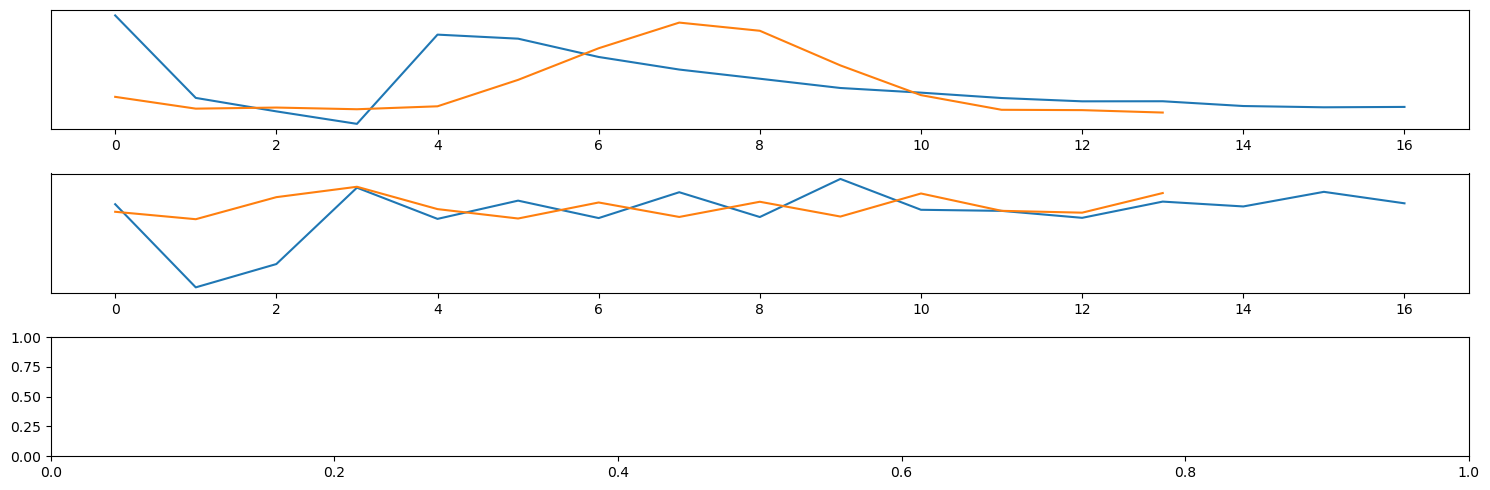

In [30]:
fig, ax = plt.subplots(max_level_of_decomposition + 1, 1, figsize=(15,5))
i=1
# for j, coef in zip(range(len(list_wavelet_coefficients)), list_wavelet_coefficients):
#     # First level is the approximation
#     if j == 0:
#         ax[j].plot(coef, label='label: ' + str(i))
#         ax[j].set_title('Approximation Coefficient.')
#     else:
#         ax[j].plot(coef, label='label: ' + str(i))
#         ax[j].set_title('Detail Coefficient: level ' + str(j) + '.')
#     ax[j].set_yticks([])

for j, coef in zip(range(len(list_wavelet_coefficients2)), list_wavelet_coefficients2):
    # First level is the approximation
    if j == 0:
        ax[j].plot(coef, label='label: ' + str(i))
    else:
        ax[j].plot(coef, label='label: ' + str(i))
    ax[j].set_yticks([])

for j, coef in zip(range(len(list_wavelet_coefficients3)), list_wavelet_coefficients3):
    # First level is the approximation
    if j == 0:
        ax[j].plot(coef, label='label: ' + str(i))
    else:
        ax[j].plot(coef, label='label: ' + str(i))
    ax[j].set_yticks([])

plt.tight_layout()

In [ ]:
a=1

In [ ]:

list_of_coeff_features_table = []
# Get features from wavelet coefficients
for coeff, decomp_level_name in zip(list_wavelet_coefficients, list_of_wavelet_decomposition_level_names):
    coeff_table = pd.DataFrame(coeff, index=signals_table.index)
    coeff_features_table = get_signal_features_table(coeff_table)
    coeff_features_table.columns = [decomp_level_name + '_' +
                                    column_name for column_name in coeff_features_table.columns]
    coeff_features_table.reset_index(inplace=True)
    list_of_coeff_features_table.append(coeff_features_table)

In [60]:
# Get training data
# table_training = table[table['Annotations'] > 0]
# Reshape table, storing one signal per row
signals_table_training = table_training.pivot(
    index='label',
    columns='frame',
    values='mean_intensity')

- get signals with annotations (DONE, currently filtering by specific label ID (to get noise parts as well))
  - get short-signals separated by class (DONE in `signal_by_class`)

  - calculate cross-correlations with composite signal(s) (DONE with one example above)

- caculate wavelets for short-signals

  - calculate cross-correlations of each short-signal decomposition level with corresponding decomposition level of composite signal(s)


- consider thrsholding or features to find potential matches
